In [1]:
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [2]:
# tokenizer 불러오기
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# 모델 불러오기 (.h5)
model = load_model('best_model.h5')

In [3]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 329,409
Trainable params: 329,409
Non-tr

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=8000, output_dim=128, input_length=70))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [5]:
import re

def clean_text(text):
    # 한글, 숫자만 남기고 나머지 제거
    text = re.sub(r"[^가-힣0-9\s]", "", str(text))
    words = text.split()
    return ' '.join(words)

In [6]:
import json
with open("pkls/v2_maxlen_70/word_index.json","r", encoding='utf-8') as f:
    word_index = json.load(f)
print(f"워드 인덱스 단어 개수 : {len(word_index)}")
vocab_size = len(word_index) + 1

워드 인덱스 단어 개수 : 7038


In [7]:
import pickle
# 학습 데이터 가져오기
with open("pkls/v2_maxlen_70/new_X_train_sequences.pickle","rb") as fr:
    X_train = pickle.load(fr)
with open("pkls/v2_maxlen_70/new_X_test_sequences.pickle","rb") as fr:
    X_test = pickle.load(fr)
# 테스트 데이터 가져오기
with open("pkls/v2_maxlen_70/new_y_train_filterd.pickle","rb") as fr:
    y_train = pickle.load(fr)
with open("pkls/v2_maxlen_70/new_y_test_filterd.pickle","rb") as fr:
    y_test = pickle.load(fr)

FileNotFoundError: [Errno 2] No such file or directory: 'pkls/v2_maxlen_70/new_X_train_sequences.pickle'

In [114]:
print("로드된 데이터 개수 :")
print(f"X_train : {len(X_train)} / y_train : {len(y_train)}")
print(f"X_test : {len(X_test)} / y_test : {len(y_test)}")

로드된 데이터 개수 :
X_train : 37385 / y_train : 37385
X_test : 9499 / y_test : 9499


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

# 1. 원래 텍스트 (str) 리스트가 필요
df = pd.read_csv("test_datas.csv")
X_train_raw = df['text'].astype(str).apply(clean_text).tolist()

# 2. 토크나이저 학습
tokenizer = Tokenizer(num_words=12000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)

# 3. 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)

# 4. 시퀀스를 패딩
X_train_pad = pad_sequences(X_train_seq, maxlen=70, padding='post', truncating='post', dtype='int32')

# pred_probs = model.predict(X_train_pad, batch_size=128)
# pred_labels = (pred_probs > 0.5).astype(int).flatten()

In [ ]:
def predict_sentiment_batch(padded_sequences, model, threshold=0.5):
    pred_probs = model.predict(padded_sequences)[:, 0]
    labels = (pred_probs > threshold).astype(int)
    return labels, pred_probs

In [101]:
from sklearn.metrics import classification_report
pred_labels, pred_probs = predict_sentiment_batch(X_train_pad, model)

323/323 [==============================] - 3s 8ms/step


In [ ]:
# 진짜 긍정만 1로 보고 싶다면:
pred_labels = (pred_probs > 0.8).astype(int)

# 아예 반대로 부정 감지하려면:
pred_labels = (pred_probs < 0.4).astype(int)

In [102]:
df['labels'] = pred_labels
df['probs'] = pred_probs.flatten()

In [103]:
df = df[['text','label','predicted_label','labels']]

In [104]:
df.to_csv("new_test_datas.csv", index=False, encoding='utf-8-sig')

In [107]:
print(df['labels'].value_counts())

labels
1    10315
Name: count, dtype: int64


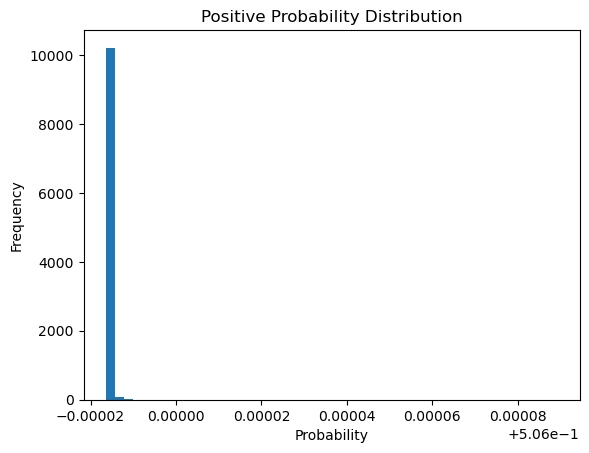

In [105]:
import matplotlib.pyplot as plt

plt.hist(pred_probs, bins=50)
plt.title("Positive Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = re.sub(r"[^가-힣0-9\s]", "", str(text))
    return ' '.join(text.split())

# 데이터 로드
train_df = pd.read_csv("data/정제_train_data.csv")
test_df = pd.read_csv("data/정제_test_data.csv")

# 전처리
train_df['text'] = train_df['text'].astype(str).apply(clean_text)
test_df['text'] = test_df['text'].astype(str).apply(clean_text)

# 텍스트 리스트
X_train = train_df['text'].tolist()
X_test = test_df['text'].tolist()

# 라벨 리스트
y_train = train_df['label'].astype(np.int32).values
y_test = test_df['label'].astype(np.int32).values

# 4. 토크나이저 학습 및 정수 인코딩
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 5. 길이 제한 후 다시 쌍 정렬
def trim_samples(X, y, max_len):
    X_out, y_out = [], []
    for x, label in zip(X, y):
        if len(x) <= max_len:
            X_out.append(x)
            y_out.append(label)
    return X_out, y_out

# 시퀀스 변환
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 패딩
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post', dtype='int32')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post', dtype='int32')


In [15]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"라벨 {label} 개수: {count}")

라벨 0 개수: 10304
라벨 1 개수: 10305


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import os
import time
import csv
from tensorflow.keras.callbacks import CSVLogger


learning_rate = 1e-4

# 실험 이름 정의 (날짜/시간 + 주요 하이퍼파라미터)
timestamp = time.strftime('%Y%m%d-%H%M%S')
experiment_name = f"exp_{timestamp}_lr{learning_rate}_bs64_lstm64"

# 디렉토리 생성
log_dir = f"./logs/{experiment_name}"
os.makedirs(log_dir, exist_ok=True)

# CSVLogger: epoch마다 val_acc, loss 등 기록
csv_logger = CSVLogger(os.path.join(log_dir, 'training_log.csv'))

# EarlyStopping & ModelCheckpoint (같이 사용)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = ModelCheckpoint(os.path.join(log_dir, 'best_model.h5'),
                     monitor='val_accuracy', save_best_only=True, verbose=1)

# 모델 구성
model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=max_len),
    LSTM(32),   # 유닛수 증가
    Dropout(0.5), # 드롭아웃 증가
    Dense(32, activation='relu'),
    Dropout(0.3), # 드롭아웃 증가
    Dense(1, activation='sigmoid')
])


# 컴파일
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

# 변경
#BATCH_SIZE = 128
BATCH_SIZE = 64

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 훈련
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[es, mc, csv_logger],
    class_weight=class_weights
)


# history 결과에서 마지막 성능 요약 저장
final_log_path = os.path.join(log_dir, 'summary.csv')
with open(final_log_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['param', 'value'])
    writer.writerow(['timestamp', timestamp])
    writer.writerow(['embedding_dim', embedding_dim])
    writer.writerow(['lstm_units', hidden_units])
    writer.writerow(['learning_rate', learning_rate])
    writer.writerow(['batch_size', BATCH_SIZE])
    writer.writerow(['max_len', max_len])
    writer.writerow(['val_accuracy_last', history.history['val_accuracy'][-1]])
    writer.writerow(['val_loss_last', history.history['val_loss'][-1]])


Epoch 1/12


c:\Users\MYCOM\.conda\envs\azen\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4991 - loss: 0.6932
Epoch 1: val_accuracy improved from -inf to 0.50412, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.4991 - loss: 0.6932 - val_accuracy: 0.5041 - val_loss: 0.6931
Epoch 2/12
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5042 - loss: 0.6932
Epoch 2: val_accuracy improved from 0.50412 to 0.50607, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5042 - loss: 0.6932 - val_accuracy: 0.5061 - val_loss: 0.6930
Epoch 3/12
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5074 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.50607
258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5074 - loss: 0.6932 - val_accuracy: 0.5056 - val_loss: 0.6930
Epoch 4/12
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4964 - loss: 0.6932
Epoch 4: val_accuracy did not improve from 0.50607
258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.4965 - loss: 0.6932 - val_accuracy: 0.5058 - val_loss: 0.6929
Epoch 5/12
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4959 - loss: 0.6930
Epoch 5: val_accuracy did not improve from 0.50607
258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.4959 - loss: 0.6930 - val_accuracy: 0.5017 - val_loss: 0.6927
Epoch 6/12
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5083 - loss: 0.6927
Epoch 6: val_accuracy i

258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5083 - loss: 0.6927 - val_accuracy: 0.5126 - val_loss: 0.6915
Epoch 7/12
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5471 - loss: 0.6789
Epoch 7: val_accuracy improved from 0.51262 to 0.83503, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5473 - loss: 0.6788 - val_accuracy: 0.8350 - val_loss: 0.5537
Epoch 8/12
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7636 - loss: 0.5416
Epoch 8: val_accuracy improved from 0.83503 to 0.85638, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7639 - loss: 0.5412 - val_accuracy: 0.8564 - val_loss: 0.3886
Epoch 9/12
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8914 - loss: 0.3735
Epoch 9: val_accuracy improved from 0.85638 to 0.90296, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8915 - loss: 0.3733 - val_accuracy: 0.9030 - val_loss: 0.3145
Epoch 10/12
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9036 - loss: 0.3475
Epoch 10: val_accuracy improved from 0.90296 to 0.91800, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9036 - loss: 0.3475 - val_accuracy: 0.9180 - val_loss: 0.2938
Epoch 11/12
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9289 - loss: 0.2865
Epoch 11: val_accuracy improved from 0.91800 to 0.91897, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9289 - loss: 0.2866 - val_accuracy: 0.9190 - val_loss: 0.2792
Epoch 12/12
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9133 - loss: 0.3253
Epoch 12: val_accuracy improved from 0.91897 to 0.91970, saving model to ./logs/exp_20250715-192729_lr0.0001_bs64_lstm64\best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9133 - loss: 0.3253 - val_accuracy: 0.9197 - val_loss: 0.2818


In [23]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=100, padding='post', truncating='post')
    prob = model.predict(pad)[0][0]
    label = '긍정' if prob > 0.5 else '부정'
    print(f"[리뷰] {text}\n→ 예측: {label} (확률: {prob:.2f})")
    return label, prob

In [24]:
predict_sentiment("사장님이 정말 친절하고 방도 깨끗해요!")
predict_sentiment("방음이 너무 안되고 시설이 낡았어요.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
[리뷰] 사장님이 정말 친절하고 방도 깨끗해요!
→ 예측: 긍정 (확률: 0.90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[리뷰] 방음이 너무 안되고 시설이 낡았어요.
→ 예측: 부정 (확률: 0.05)


('부정', np.float32(0.052923147))

In [25]:
final_model_path = os.path.join(log_dir, 'final_model.keras')
model.save(final_model_path)

In [ ]:
#!pip install --upgrade transformers datasets accelerate
#!pip install tf-keras

#!pip show transformers

Name: transformers
Version: 4.53.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: c:\users\mycom\.conda\envs\azen\lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [39]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)

transformers.training_args


In [38]:
from transformers import Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import torch

#  1. 데이터 로딩
df = pd.read_csv("data/정제_train_data.csv")  # 반드시 text, label 컬럼 있어야 함
df = df[['text', 'label']]  # label: 0=부정, 1=긍정

#  2. 학습/검증 분할
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

#  3. Huggingface Datasets 변환
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

#  4. Tokenizer 및 전처리 함수
model_name = "klue/roberta-base"  # 또는 "monologg/kobert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

#  5. 모델 정의 (2 클래스 분류)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

#  6. 훈련 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True # 추가

)

#  7. 평가 지표 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = np.mean(preds == labels)
    return {"accuracy": acc}

#  8. Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

#  9. 모델 학습
trainer.train()

#  10. 예측 결과 출력
preds = trainer.predict(test_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

print("\n 평가 결과:")
print(classification_report(true_labels, pred_labels, target_names=["부정", "긍정"]))


Map: 100%|██████████| 4122/4122 [00:00<00:00, 9579.54 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
import pickle

with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import matplotlib.pyplot as plt

loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f}")

# 시각화
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training History")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

# 예시 출력
for i in range(5):
    print(f"{X_test[i]}")
    print(f"실제: {y_test[i]} / 예측: {y_pred[i][0]}")
    print("-" * 40)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_model_keras.keras")

In [ ]:
import pandas as pd
import numpy as np

# 예측 확률 → 0.5 기준 이진 분류
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# 결과 DataFrame 생성
results_df = pd.DataFrame({
    'text': X_test,  # 원문 텍스트
    'true_label': y_test,
    'pred_label': y_pred,
    'pred_prob': y_pred_probs.flatten()
})

# 저장
results_df.to_csv("lstm_predictions.csv", index=False, encoding="utf-8-sig")
print("예측 결과가 lstm_predictions.csv에 저장되었습니다.")

In [ ]:
!pip install wordcloud

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

def extract_nouns(texts):
    from konlpy.tag import Okt
    okt = Okt()
    all_nouns = []
    for text in texts:
        nouns = okt.nouns(str(text))
        nouns = [n for n in nouns if len(n) > 1]  # 1글자 제외
        all_nouns.extend(nouns)
    return all_nouns

# 예측 기준 분리
positive_texts = results_df[results_df['pred_label'] == 1]['text'].tolist()
negative_texts = results_df[results_df['pred_label'] == 0]['text'].tolist()

# 키워드 추출
positive_nouns = extract_nouns(positive_texts)
negative_nouns = extract_nouns(negative_texts)

# 빈도수 계산
pos_freq = Counter(positive_nouns)
neg_freq = Counter(negative_nouns)

def generate_wordcloud(freq_dict, title, font_path='NanumGothic.ttf'):
    wc = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white'
    )
    wc_img = wc.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc_img, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(pos_freq, "pos")
generate_wordcloud(neg_freq, "neg")

wc = WordCloud(font_path='NanumGothic.ttf', width=800, height=400, background_color='white')
wc.generate_from_frequencies(pos_freq).to_file("positive_wordcloud.png")
wc.generate_from_frequencies(neg_freq).to_file("negative_wordcloud.png")

In [ ]:
!pip cache purge

In [ ]:
model.save("best_model.keras")

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.9.0

In [ ]:
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

In [1]:
from tensorflow.keras.models import load_model
model = load_model("best_model_keras.keras")

In [ ]:
import pandas as pd
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

# 모델 로드
# model = load_model("best_model_keras.keras")
# model = load_model("best_model.h5", compile=False)

# 토크나이저 로드
import pickle
with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

# 데이터 불러오기 (예: 실제 리뷰)
df = pd.read_csv("y_reviews.csv")
texts = df['review_content'].tolist()

# 전처리 및 시퀀스 변환
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=30)  # maxlen은 학습 때 사용한 값과 동일하게

# 예측
probs = model.predict(padded)
preds = (probs > 0.5).astype(int).flatten()

# 결과 추가
df['predicted_label'] = preds
df['sentiment_score'] = probs.flatten()  # 0~1 감성 점수

# 저장
df.to_csv("예측된_감성_리뷰.csv", index=False, encoding='utf-8-sig')


In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['sentiment_score'], bins=50)
plt.title("감성 점수 분포")
plt.xlabel("sentiment_score")
plt.ylabel("리뷰 수")
plt.axvline(0.5, color='gray', linestyle='--')
plt.show()

In [ ]:
def classify_3way(score, center=0.5, neutral_margin=0.01):
    if abs(score - center) < neutral_margin:
        return "중립"
    elif score >= center + neutral_margin:
        return "긍정"
    else:
        return "부정"

In [ ]:
df['predicted_label_3way'] = df['sentiment_score'].apply(classify_3way)
df.to_csv("예측된_감성_리뷰.csv", index=False, encoding='utf-8-sig')